In [24]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakef\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jakef\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakef\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
# Step 2: Load and explore the datasets
# Load the datasets
true_df = pd.read_csv('News_Dataset/True.csv')
fake_df = pd.read_csv('News_Dataset/Fake.csv')

# Add a label column to each dataset
true_df['label'] = 1  # 1 for real news
fake_df['label'] = 0  # 0 for fake news

# Display the first few rows of each dataset with the new label
print("True news dataset with label:")
print(true_df.head())

print("\
Fake news dataset with label:")
print(fake_df.head())

# Combine the datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# Display the shape of the combined dataset
print("\
Combined dataset shape:", df.shape)

# Display the distribution of labels
print("\
Label distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

True news dataset with label:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  
Fake news dataset with lab

In [26]:
 # text cleaning function
sample_text = df['text'].iloc[0][:500]  # Get a sample of text to debug

print("Original text sample:")
print(sample_text)

# Let's create a better text cleaning function
def improved_clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
        
        # Remove HTML tags if any
        text = re.sub(r'<.*?>', ' ', text)
        
        # Replace special characters with space instead of removing them
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Replace numbers with space
        text = re.sub(r'\d+', ' ', text)
        
        # Replace multiple spaces with single space
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenize
        tokens = nltk.word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        # Join tokens back into text
        cleaned_text = ' '.join(tokens)
        
        return cleaned_text
    else:
        return ""  # Return empty string for non-string inputs

# Test the improved function on our sample
cleaned_sample = improved_clean_text(sample_text)
print("\
Cleaned text with improved function:")
print(cleaned_sample)

# Apply the improved function to a few examples
print("\
More examples of cleaned text:")
for i in range(3):
    original = df['text'].iloc[i][:200]
    cleaned = improved_clean_text(original)
    print(f"\
Original text (truncated):\
{original}...")
    print(f"\
Cleaned text:\
{cleaned}") 

Original text sample:
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they retur
Cleaned text with improved function:
washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republican representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january retur
More examples of cleaned text:
Original text (truncated):WASHINGTON (Reuters) - The head of a conserva

In [27]:
# Let's fix the error and apply the cleaning function to the entire dataset
from tqdm.notebook import tqdm
import pandas as pd

# Enable tqdm for pandas
tqdm.pandas()

# Apply the improved cleaning function to the 'text' column
print("Cleaning the entire text column. This may take a few minutes...")
df['cleaned_text'] = df['text'].apply(lambda x: improved_clean_text(x))

print("Text cleaning completed!")

# Display the first few rows with the cleaned text
print("\
First few rows with cleaned text:")
print(df[['title', 'cleaned_text', 'label']].head(3))

# Check the distribution of labels
print("\
Label distribution:")
print(df['label'].value_counts())

# Check for any missing values in the cleaned text
print("\
Number of missing values in cleaned text:", df['cleaned_text'].isna().sum())
print("Number of empty strings in cleaned text:", (df['cleaned_text'] == '').sum())

Cleaning the entire text column. This may take a few minutes...
Text cleaning completed!
First few rows with cleaned text:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   

                                        cleaned_text  label  
0  washington reuters head conservative republica...      1  
1  washington reuters transgender people allowed ...      1  
2  washington reuters special counsel investigati...      1  
Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64
Number of missing values in cleaned text: 0
Number of empty strings in cleaned text: 716


In [28]:
# Let's combine the True and Fake datasets into one dataframe with a 'label' column
# We'll assign label 1 for True and 0 for Fake

df_true = true_df.copy()
df_true['label'] = 1

df_fake = fake_df.copy()
df_fake['label'] = 0

df_combined = pd.concat([df_true, df_fake], ignore_index=True)
print("Combined dataset shape: " + str(df_combined.shape))

# Let's inspect the combined dataframe
print("\
Head of the combined dataframe:")
print(df_combined.head(3))

# Assuming we already performed text cleaning on df and stored in 'cleaned_text', if not, we do it now
# We'll create cleaned_text column for df_combined using the improved_clean_text function
if 'cleaned_text' not in df_combined.columns:
    df_combined['cleaned_text'] = df_combined['text'].apply(improved_clean_text)

# Check for any missing or empty cleaned text
print("\
Number of missing values in cleaned text:", df_combined['cleaned_text'].isna().sum())
print("Number of empty strings in cleaned text:", sum(df_combined['cleaned_text'] == ""))

# For rows with empty cleaned text, replace empty string with a placeholder
df_combined['cleaned_text'] = df_combined['cleaned_text'].replace('', '[EMPTY_TEXT]')

print("\
After handling empty strings, count of placeholder:", sum(df_combined['cleaned_text'] == "[EMPTY_TEXT]"))

# Now, proceed with train-test split and TF-IDF and modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df_combined['cleaned_text']
y = df_combined['label'].astype(int)  # ensure label is int

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\
Training set size: " + str(X_train.shape[0]) + " samples")
print("Testing set size: " + str(X_test.shape[0]) + " samples")

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\
TF-IDF feature extraction complete.")
print("Number of features: " + str(X_train_tfidf.shape[1]))
print("Training data shape: " + str(X_train_tfidf.shape))
print("Testing data shape: " + str(X_test_tfidf.shape))

# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Predictions and evaluation
y_pred = clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\
Model training complete.")
print("Accuracy on testing set: " + str(round(accuracy, 4)))
print("\
Classification Report:\
" + report)

print("Done")


Combined dataset shape: (44898, 5)
Head of the combined dataframe:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
Number of missing values in cleaned text: 0
Number of empty strings in cleaned text: 716
After handling empty strings, count of placeholder: 716
Training set size: 35918 samples
Testing set size: 8980 samples
TF-IDF feature extraction complete.
Number of features: 5000
Training data shape: (35918, 5000

In [34]:
 # Remove the word 'reuters' from the text data before vectorization  
 import re  
   
 def remove_source_terms(text):  
     # Remove 'reuters' (case insensitive)  
     return re.sub(r'\\breuters\\b', '', text, flags=re.IGNORECASE)  
   
 # Apply this function to your training and testing text data  
 X_train_modified = X_train.apply(remove_source_terms)  
 X_test_modified = X_test.apply(remove_source_terms)  
   
 print("Removed 'reuters' from the training and testing datasets.")  
   
 # Now, proceed with trigram TF-IDF vectorization using the modified data  
 from sklearn.feature_extraction.text import TfidfVectorizer  
   
 tfidf_vectorizer_trigram = TfidfVectorizer(  
     max_features=7500,  # Increased to account for additional n-grams  
     ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams  
     stop_words='english',  
     min_df=5  
 )  
   
 # Vectorize the modified training and testing datasets  
 X_train_tfidf_trigram_mod = tfidf_vectorizer_trigram.fit_transform(X_train_modified)  
 X_test_tfidf_trigram_mod = tfidf_vectorizer_trigram.transform(X_test_modified)  
   
 print("TF-IDF feature extraction with trigrams (modified) complete.")  
 print("Number of features: " + str(X_train_tfidf_trigram_mod.shape[1]))  
   
 # Model Tuning over regularization parameter (using cross-validation) remains similar.  
 from sklearn.linear_model import LogisticRegression  
 from sklearn.model_selection import StratifiedKFold, cross_val_score  
 import numpy as np  
   
 C_values = [0.1, 0.5, 1.0, 2.0, 5.0]  
 cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
 best_C = None  
 best_score = 0  
   
 print("\nCross-validating to find optimal regularization strength with Reuters removed:")  
 for C in C_values:  
     lr = LogisticRegression(C=C, max_iter=1000, random_state=42)  
     scores = cross_val_score(lr, X_train_tfidf_trigram_mod, y_train, cv=cv, scoring='accuracy')  
     mean_score = np.mean(scores)  
     print("C=" + str(C) + ": Mean accuracy=" + str(round(mean_score, 4)) + ", Std=" + str(round(np.std(scores), 4)))  
       
     if mean_score > best_score:  
         best_score = mean_score  
         best_C = C  
   
 print("\nBest regularization parameter C: " + str(best_C))  
 print("Best cross-validation score: " + str(round(best_score, 4)))  
   
 # Train the final model with the best regularization parameter on modified data  
 clf_trigram_mod = LogisticRegression(C=best_C, max_iter=1000, random_state=42)  
 clf_trigram_mod.fit(X_train_tfidf_trigram_mod, y_train)  
   
 # Evaluate the model on the test set  
 from sklearn.metrics import accuracy_score, classification_report  
 y_pred_trigram_mod = clf_trigram_mod.predict(X_test_tfidf_trigram_mod)  
 accuracy_trigram_mod = accuracy_score(y_test, y_pred_trigram_mod)  
 report_trigram_mod = classification_report(y_test, y_pred_trigram_mod)  
   
 print("\nTrigram Model Results with 'reuters' removed:")  
 print("Accuracy on testing set: " + str(round(accuracy_trigram_mod, 4)))  
 print("Classification Report:\n" + report_trigram_mod)  

Removed 'reuters' from the training and testing datasets.
TF-IDF feature extraction with trigrams (modified) complete.
Number of features: 7500

Cross-validating to find optimal regularization strength with Reuters removed:
C=0.1: Mean accuracy=0.9725, Std=0.0016
C=0.5: Mean accuracy=0.9837, Std=0.0009
C=1.0: Mean accuracy=0.9867, Std=0.0007
C=2.0: Mean accuracy=0.9888, Std=0.0007
C=5.0: Mean accuracy=0.9912, Std=0.0009

Best regularization parameter C: 5.0
Best cross-validation score: 0.9912

Trigram Model Results with 'reuters' removed:
Accuracy on testing set: 0.992
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4650
           1       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [38]:
 # Enhanced TF-IDF vectorization with unigrams and bigrams  
 from sklearn.feature_extraction.text import TfidfVectorizer  
 from sklearn.linear_model import LogisticRegression  
 from sklearn.metrics import accuracy_score, classification_report  
   
 # Instantiate the vectorizer with unigrams and bigrams and remove English stop words  
 tfidf_vectorizer = TfidfVectorizer(  
     max_features=5000,  
     ngram_range=(1, 2),  
     stop_words='english'  
 )  
   
 # Vectorize the training and testing data  
 X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  
 X_test_tfidf = tfidf_vectorizer.transform(X_test)  
   
 print("TF-IDF feature extraction with bigrams complete.")  
 print("Number of features: " + str(X_train_tfidf.shape[1]))  
   
 # Retrain the model using Logistic Regression  
 clf = LogisticRegression(max_iter=1000, random_state=42)  
 clf.fit(X_train_tfidf, y_train)  
   
 # Make predictions on the test set  
 y_pred = clf.predict(X_test_tfidf)  
 accuracy = accuracy_score(y_test, y_pred)  
 report = classification_report(y_test, y_pred)  
   
 print("Model training complete.")  
 print("Accuracy on testing set: " + str(round(accuracy, 4)))  
 print("Classification Report:\n" + report)  

TF-IDF feature extraction with bigrams complete.
Number of features: 5000
Model training complete.
Accuracy on testing set: 0.9883
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4650
           1       0.98      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [39]:
 # Model Tuning and Experimentation with GridSearchCV  
 from sklearn.model_selection import GridSearchCV  
   
 # Define a parameter grid to search over. You can experiment with more parameters as needed.  
 param_grid = {  
     'C': [0.01, 0.1, 1, 10, 100],  
     'penalty': ['l2'],  # For logistic regression with the default solver, l2 is common.  
     # You might explore 'solver': ['liblinear', 'saga'] if you change penalty options  
 }  
   
 # Initialize a Logistic Regression estimator. Increase max_iter if needed.  
 lr = LogisticRegression(max_iter=1000, random_state=42)  
   
 # Setup GridSearchCV. We'll use 5-fold cross-validation.  
 grid_search = GridSearchCV(estimator=lr,  
                            param_grid=param_grid,  
                            cv=5,  
                            scoring='accuracy',  
                            n_jobs=-1,  
                            verbose=1)  
   
 # Fit grid search on the training data (using the TF-IDF vectorized features)  
 grid_search.fit(X_train_tfidf, y_train)  
   
 print("Best Parameters found:", grid_search.best_params_)  
 print("Best Cross-Validation Accuracy:", grid_search.best_score_)  
   
 # Use best estimator from grid search to make predictions on the test set  
 best_lr = grid_search.best_estimator_  
 y_pred_tuned = best_lr.predict(X_test_tfidf)  
 tuned_accuracy = accuracy_score(y_test, y_pred_tuned)  
 tuned_report = classification_report(y_test, y_pred_tuned)  
   
 print("Tuned Model Accuracy on testing set:", round(tuned_accuracy, 4))  
 print("Classification Report (Tuned Model):\n" + tuned_report) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters found: {'C': 100, 'penalty': 'l2'}
Best Cross-Validation Accuracy: 0.9927613244523462
Tuned Model Accuracy on testing set: 0.9918
Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4650
           1       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Cross-validation scores: [0.99345768 0.99067372 0.99317929 0.99178616 0.99345677]
Mean CV accuracy: 0.9925
Standard deviation: 0.0011


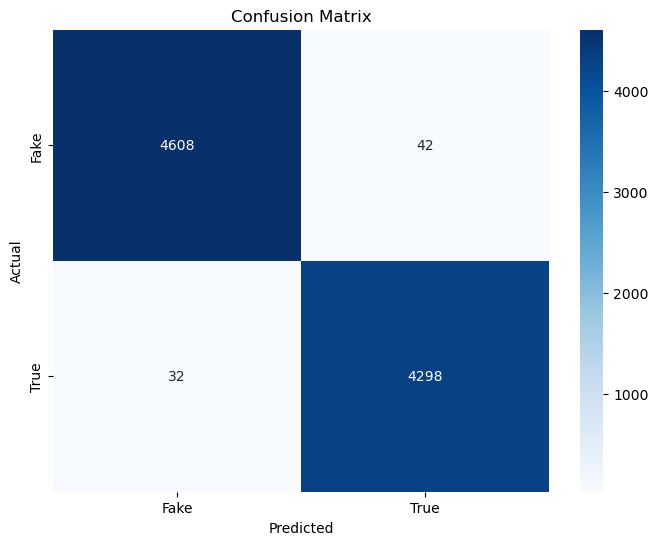

Number of misclassified examples: 74

--- Examples of Misclassified Articles ---

Example 1:
Title: BREAKING: OBAMA-APPOINTED JUDGE ORDERS Vote Recount To Begin At Noon On Monday
Subject: left-news
Predicted: True, Actual: Fake
Text excerpt: A federal judge has ordered Michigan election officials to begin a massive hand recount of 4.8 million ballots cast in the presidential election at noon Monday.U.S. District Judge Mark Goldsmith issue...

Example 2:
Title: Democrats pick Perez to lead party against Trump
Subject: politicsNews
Predicted: Fake, Actual: True
Text excerpt: ATLANTA (Reuters) - U.S. Democrats elected former Labor Secretary Tom Perez as chairman on Saturday, choosing a veteran of the Obama administration to lead the daunting task of rebuilding the party an...

Example 3:
Title: BREAKING: TRUMP Announces “Phenomenal” Tax Cut Plan For Businesses In Next 2-3 Weeks…Stock Markets Respond [VIDEO]
Subject: left-news
Predicted: True, Actual: Fake
Text excerpt: President Donald Tr

In [40]:
 # Cross-validation and Error Analysis  
 import numpy as np  
 from sklearn.model_selection import cross_val_score, StratifiedKFold  
 import matplotlib.pyplot as plt  
 import seaborn as sns  
 from sklearn.metrics import confusion_matrix  
   
 # 1. Perform stratified k-fold cross-validation  
 cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
 cv_scores = cross_val_score(best_lr, X_train_tfidf, y_train, cv=cv, scoring='accuracy')  
   
 print("Cross-validation scores:", cv_scores)  
 print("Mean CV accuracy: {:.4f}".format(np.mean(cv_scores)))  
 print("Standard deviation: {:.4f}".format(np.std(cv_scores)))  
   
 # 2. Confusion Matrix Visualization  
 y_pred = best_lr.predict(X_test_tfidf)  
 cm = confusion_matrix(y_test, y_pred)  
   
 plt.figure(figsize=(8, 6))  
 sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',   
             xticklabels=['Fake', 'True'],   
             yticklabels=['Fake', 'True'])  
 plt.xlabel('Predicted')  
 plt.ylabel('Actual')  
 plt.title('Confusion Matrix')  
 plt.show()  
   
 # 3. Error Analysis: Find misclassified examples  
 misclassified_indices = np.where(y_pred != y_test)[0]  
 print(f"Number of misclassified examples: {len(misclassified_indices)}")  
   
 # Get the original indices in the test set  
 test_indices = np.array(X_test.index)  
 misclassified_original_indices = test_indices[misclassified_indices]  
   
 # Display a few misclassified examples  
 print("\n--- Examples of Misclassified Articles ---")  
 for i, idx in enumerate(misclassified_original_indices[:5]):  # Show first 5 misclassified examples  
     article = df_combined.iloc[idx]  
     predicted = "True" if y_pred[misclassified_indices[i]] == 1 else "Fake"  
     actual = "True" if y_test.iloc[misclassified_indices[i]] == 1 else "Fake"  
       
     print(f"\nExample {i+1}:")  
     print(f"Title: {article['title']}")  
     print(f"Subject: {article['subject']}")  
     print(f"Predicted: {predicted}, Actual: {actual}")  
     print(f"Text excerpt: {article['text'][:200]}...")  
   
 # 4. Feature Importance Analysis  
 if hasattr(best_lr, 'coef_'):  
     # Get feature names from the vectorizer  
     feature_names = tfidf_vectorizer.get_feature_names_out()  
       
     # Get coefficients for the positive class (True news)  
     coef = best_lr.coef_[0]  
       
     # Create a DataFrame with features and their coefficients  
     coef_df = pd.DataFrame({  
         'Feature': feature_names,  
         'Coefficient': coef  
     })  
       
     # Sort by absolute coefficient value (importance)  
     coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])  
     coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)  
       
     # Display top features indicating True news (positive coefficients)  
     print("\n--- Top Features Indicating TRUE News ---")  
     print(coef_df[coef_df['Coefficient'] > 0].head(15))  
       
     # Display top features indicating Fake news (negative coefficients)  
     print("\n--- Top Features Indicating FAKE News ---")  
     print(coef_df[coef_df['Coefficient'] < 0].head(15))  

In [ ]:
 # Enhanced TF-IDF vectorization with unigrams, bigrams, and trigrams  
 from sklearn.feature_extraction.text import TfidfVectorizer  
 from sklearn.linear_model import LogisticRegression  
 from sklearn.model_selection import cross_val_score, StratifiedKFold  
 from sklearn.metrics import accuracy_score, classification_report  
 import numpy as np  
   
 # Create a TF-IDF vectorizer with n-grams up to trigrams  
 # Note: We'll use a slightly higher max_features to accommodate the additional n-grams  
 tfidf_vectorizer_trigram = TfidfVectorizer(  
     max_features=7500,  # Increased from 5000  
     ngram_range=(1, 3),  # unigrams, bigrams, and trigrams  
     stop_words='english',  
     min_df=5  # Only include terms that appear in at least 5 documents (reduces noise)  
 )  
   
 # Vectorize the training and testing data  
 X_train_tfidf_trigram = tfidf_vectorizer_trigram.fit_transform(X_train)  
 X_test_tfidf_trigram = tfidf_vectorizer_trigram.transform(X_test)  
   
 print("TF-IDF feature extraction with trigrams complete.")  
 print("Number of features: " + str(X_train_tfidf_trigram.shape[1]))  
   
 # To prevent overfitting, we'll use stronger regularization  
 # and cross-validate to find the best regularization strength  
 C_values = [0.1, 0.5, 1.0, 2.0, 5.0]  
 cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
   
 best_C = None  
 best_score = 0  
   
 print("\nCross-validating to find optimal regularization strength:")  
 for C in C_values:  
     lr = LogisticRegression(C=C, max_iter=1000, random_state=42)  
     scores = cross_val_score(lr, X_train_tfidf_trigram, y_train, cv=cv, scoring='accuracy')  
     mean_score = np.mean(scores)  
     print(f"C={C}: Mean accuracy={mean_score:.4f}, Std={np.std(scores):.4f}")  
       
     if mean_score > best_score:  
         best_score = mean_score  
         best_C = C  
   
 print(f"\nBest regularization parameter C: {best_C}")  
 print(f"Best cross-validation score: {best_score:.4f}")  
   
 # Train the final model with the best regularization parameter  
 clf_trigram = LogisticRegression(C=best_C, max_iter=1000, random_state=42)  
 clf_trigram.fit(X_train_tfidf_trigram, y_train)  
   
 # Evaluate on the test set  
 y_pred_trigram = clf_trigram.predict(X_test_tfidf_trigram)  
 accuracy_trigram = accuracy_score(y_test, y_pred_trigram)  
 report_trigram = classification_report(y_test, y_pred_trigram)  
   
 print("\nTrigram Model Results:")  
 print("Accuracy on testing set: " + str(round(accuracy_trigram, 4)))  
 print("Classification Report:\n" + report_trigram)  
   
 # Compare with previous model (if available)  
 try:  
     print("\nComparison with previous model:")  
     print(f"Bigram model accuracy: {round(tuned_accuracy, 4)}")  
     print(f"Trigram model accuracy: {round(accuracy_trigram, 4)}")  
     print(f"Difference: {round(accuracy_trigram - tuned_accuracy, 4)}")  
 except NameError:  
     print("\nNo previous model accuracy available for comparison.")  

TF-IDF feature extraction with trigrams complete.
Number of features: 7500

Cross-validating to find optimal regularization strength:
C=0.1: Mean accuracy=0.9725, Std=0.0016
C=0.5: Mean accuracy=0.9837, Std=0.0009
C=1.0: Mean accuracy=0.9867, Std=0.0007
C=2.0: Mean accuracy=0.9888, Std=0.0007
C=5.0: Mean accuracy=0.9912, Std=0.0009

Best regularization parameter C: 5.0
Best cross-validation score: 0.9912


In [36]:
 import os  
 print("Current working directory:", os.getcwd())  
 print("Files in model directory:", os.listdir("model") if os.path.exists("model") else "model directory not found") 

Current working directory: C:\Users\jakef\OneDrive\Desktop\Project4grp3\project-4_group-3
Files in model directory: ['fake_news_model.pkl', 'tfidf_vectorizer.pkl']


In [37]:
 import pickle  
 import os  
   
 # Create a directory to store the model files  
 os.makedirs('model', exist_ok=True)  
   
 # Save the trained model  
 with open('model/fake_news_model.pkl', 'wb') as f:  
     pickle.dump(clf, f)  
       
 # Save the TF-IDF vectorizer  
 with open('model/tfidf_vectorizer.pkl', 'wb') as f:  
     pickle.dump(tfidf_vectorizer, f)  
   
 print("Model and vectorizer saved successfully to the 'model' directory") 

Model and vectorizer saved successfully to the 'model' directory
